In [3]:
#Installing packages and loading them into the enviroment
install.packages("MASS")
library("MASS")
install.packages("missMDA")
library("missMDA")
install.packages("tidyverse")
library("tidyverse")
install.packages("caret")
library("caret")
install.packages("mice")
library("mice")
install.packages("viridis")
library("viridis")

Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'MASS' is in use and will not be installed"
Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'missMDA' is in use and will not be installed"
Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'tidyverse' is in use and will not be installed"
Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'caret' is in use and will not be installed"
Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning message:
"package 'mice' is in use and will not be installed"
Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

Warning mes

In [193]:
#Loading all needed files,dropping first two coloumns, which are not needed for analysis (ID, species)
ionomics <- read.csv('spec_woAestAcerPalmVulp_shoot_xyz_concat.csv', colClasses =c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))
hybrids <- read.csv('spec_shoot_xyz_concat_unk_only.csv', colClasses = c("NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                        NA,NA,NA,NA,NA,NA,NA))
#Imputation via missMDA
imputeIonomics <- imputePCA(ionomics, method = "Regularized")

In [123]:
#Imputation via Mice
# TODO add in fit graphics and missing data quantification
temp <- mice(ionomics, m = 1, maxit = 5, method = "norm.boot", seed = 567)
ionomicsComplete <- complete(temp,1)


 iter imp variable
  1   1  S34_X
  2   1  S34_X
  3   1  S34_X
  4   1  S34_X
  5   1  S34_X


In [6]:
#data imputed with missMDA regularized method
mean.impute <- 0 #Start our average with 0
for (x in 1:1000){ # run 1000 permutations
    set.seed(x) #cycle through many random generator seeds
    training.samples.impute <- imputeIonomics$completeObs[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ] #generate training set
    test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ] #generate test set
    train.data.impute <- unlist(train.data.impute) #typecast from matrix into dataframe
    test.data.impute <- unlist(test.data.impute)
    train.data.impute <- as.data.frame(train.data.impute)
    test.data.impute <- as.data.frame(test.data.impute)
    model.impute <- lda(spec_as_int~., data = train.data.impute) #generate the LDA model
    predictions.impute <- model.impute %>% predict(test.data.impute) #predict the species of individuals in our test set based off of this model
    mean.impute = mean.impute + mean(predictions.impute$class==test.data.impute$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.impute = mean.impute/999 #divide running total by number of runs to find our average
mean.impute #print this average to the screen

[1] 0.8551051

In [7]:
#data imputed with mice, norm.boot method
mean.mice = 0 #Start our average with 0
for (x in 1:1000){ #run 10000 permutations
    set.seed(x)  #cycle through many random generator seeds
    training.samples.mice <- ionomicsComplete[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.mice <- ionomicsComplete[training.samples.mice, ] #generate training set
    test.data.mice <- ionomicsComplete[-training.samples.mice, ] #generate test set
    model.mice <- lda(spec_as_int~., data = train.data.mice) #generate the LDA model
    predictions.mice <- model.mice %>% predict(test.data.mice) #predict the species of individuals in our test set based off of this model
    mean.mice = mean.mice + mean(predictions.mice$class==test.data.mice$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.mice = mean.mice/999 #divide running total by number of runs to find our average
mean.mice #print this average to the screen

[1] 0.8553241

In [194]:
df.impute <- as.data.frame(unlist(imputeIonomics$completeObs))
lda.impute <- lda(spec_as_int~., data = df.impute)
pred.impute <- predict(lda.impute)
pred.hybrids <- lda.impute %>% predict(hybrids)

In [195]:
viz.impute <- data.frame(spec = df.impute[1], lda = pred.impute$x)
viz.hybrids <- data.frame(spec = hybrids[2], lda = pred.hybrids$x)
viz.impute$spec = as.factor(viz.impute$spec)
viz.hybrids$spec = as.factor(viz.hybrids$spec)
row.names(viz.hybrids) = unlist(hybrids[1])
viz.hybrids

,spec_as_int,lda.LD1,lda.LD2,lda.LD3,spec
,<int>,<dbl>,<dbl>,<dbl>,<fct>
V._candicans_or_hybrid,30,-0.5297356188,0.5662986,-0.6094765,30
V._riparia_or_vulpina,31,4.7966376981,-1.8711273,-4.7490031,31
V._unk_NY_a,32,2.6727379078,1.9157437,0.7359220,32
V._unk_NY_b,33,0.0003084282,-1.8734644,0.2504446,33
V._unk_PA,34,-3.0909011097,-9.7387830,-7.9806505,34
V._unk,35,0.6141437703,-2.3911309,-2.3673606,35
V._unk_NY_c,36,0.6043256165,-2.2506934,-2.0678278,36
V._unk_NY_d,37,0.1127374252,-2.1494215,-1.9994755,37
V._andersonii_V. coignetiae x V. riparia (vulpina),38,1.8717464316,-0.3228269,-0.2046044,38


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
"Ignoring unknown parameters: label_padding"


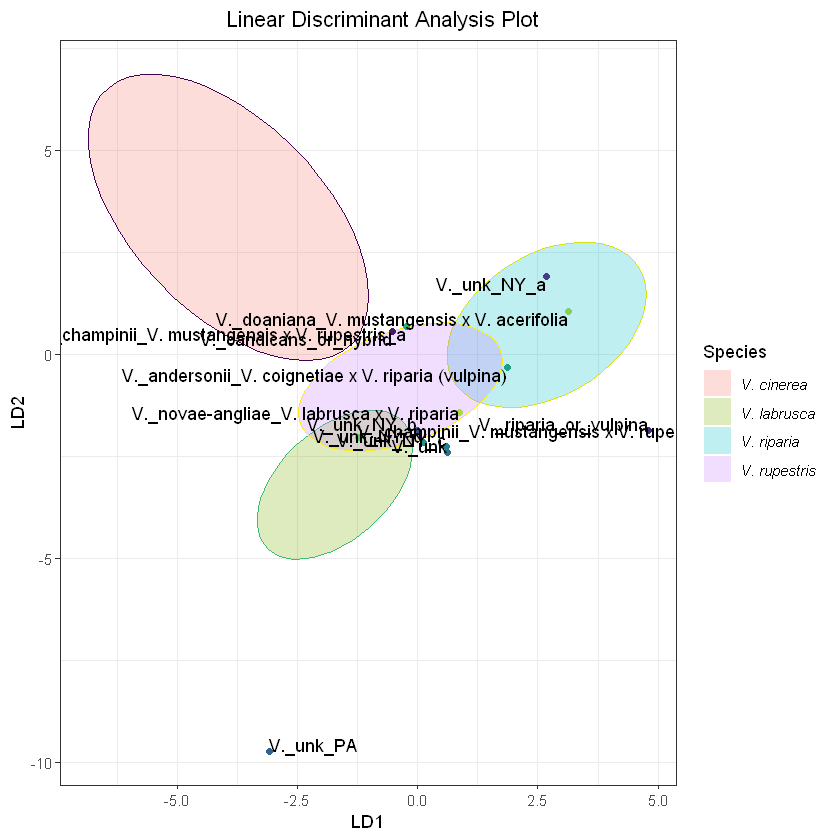

In [198]:
p <- ggplot(data = NULL) + 
    stat_ellipse(data = viz.impute, 
    aes(x = lda.LD1, y = lda.LD2, color = spec, fill = spec),geom = "polygon", alpha = .25)+
    geom_point(data = viz.hybrids, aes(x = lda.LD1, y = lda.LD2, color = spec))
p <- p + scale_color_viridis_d(aesthetics = "fill")
p <- p + scale_color_viridis_d(aesthetics = "color")
p <- p + theme_bw()
p <- p + xlab("LD1")
p <- p + ylab("LD2")
p <- p + labs(title = "Linear Discriminant Analysis Plot")
p <- p + theme(plot.title = element_text(hjust = .55), legend.text = element_text(face = "italic"))
p <- p + scale_fill_discrete(name = "Species", labels = c("V. cinerea","V. labrusca","V. riparia","V. rupestris"))
p <- p + guides(color = FALSE)
p <- p + geom_text(aes(x = viz.hybrids$lda.LD1, y = viz.hybrids$lda.LD2), label = rownames(viz.hybrids), vjust = "inward",
                 hjust = "inward")
p

|species|spec_as_int|
|---|---|
|acerifolia_x|1|
|cinerea_x|3|
|labrusca_x|4|
|riparia_x|6|
|rupestris_x|7|
|vulpina_x|8|

In [26]:
#mice data
table.mice <- table(Predicted=predictions.mice$class, Species=test.data.mice$spec_as_int)
confusionMatrix(table.mice)

Confusion Matrix and Statistics

         Species
Predicted  3  4  6  7
        3  4  0  0  0
        4  0  7  1  1
        6  0  0 10  0
        7  0  0  0  9

Overall Statistics
                                          
               Accuracy : 0.9375          
                 95% CI : (0.7919, 0.9923)
    No Information Rate : 0.3438          
    P-Value [Acc > NIR] : 2.701e-12       
                                          
                  Kappa : 0.9141          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 3 Class: 4 Class: 6 Class: 7
Sensitivity             1.000   1.0000   0.9091   0.9000
Specificity             1.000   0.9200   1.0000   1.0000
Pos Pred Value          1.000   0.7778   1.0000   1.0000
Neg Pred Value          1.000   1.0000   0.9545   0.9565
Prevalence              0.125   0.2188   0.3438   0.3125
Detection Rate          0.125   0.2188   0.3125   0.2812
Detection P

In [27]:
#missMDA data
table.impute <- table(Predicted=predictions.impute$class, Species=test.data.impute$spec_as_int)
confusionMatrix(table.impute)

Confusion Matrix and Statistics

         Species
Predicted  3  4  6  7
        3  4  0  0  0
        4  0  7  1  1
        6  0  0 10  0
        7  0  0  0  9

Overall Statistics
                                          
               Accuracy : 0.9375          
                 95% CI : (0.7919, 0.9923)
    No Information Rate : 0.3438          
    P-Value [Acc > NIR] : 2.701e-12       
                                          
                  Kappa : 0.9141          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 3 Class: 4 Class: 6 Class: 7
Sensitivity             1.000   1.0000   0.9091   0.9000
Specificity             1.000   0.9200   1.0000   1.0000
Pos Pred Value          1.000   0.7778   1.0000   1.0000
Neg Pred Value          1.000   1.0000   0.9545   0.9565
Prevalence              0.125   0.2188   0.3438   0.3125
Detection Rate          0.125   0.2188   0.3125   0.2812
Detection P